# Task2:乙醇销售数据回归

In [1]:
# 导入库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import random
import torch.nn.functional as F
torch.set_default_tensor_type(torch.DoubleTensor)

In [2]:
device = torch.device('cuda:2')

### 数据处理

In [3]:
# 读取原始文件，并设置日期为索引
data = pd.read_csv('alcohol.csv', index_col='DATE')
# 将data_index设置为时间格式
data.index = pd.to_datetime(data.index)
time = data.index

# 转为 array
data = data['S4248SM144NCEN']
series = np.array(data)

In [4]:
time

DatetimeIndex(['1992-01-01', '1992-02-01', '1992-03-01', '1992-04-01',
               '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01',
               '1992-09-01', '1992-10-01',
               ...
               '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
               '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01',
               '2018-12-01', '2019-01-01'],
              dtype='datetime64[ns]', name='DATE', length=325, freq=None)

### 数据可视化

In [5]:
# 定义绘制函数
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    # 设置图例
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

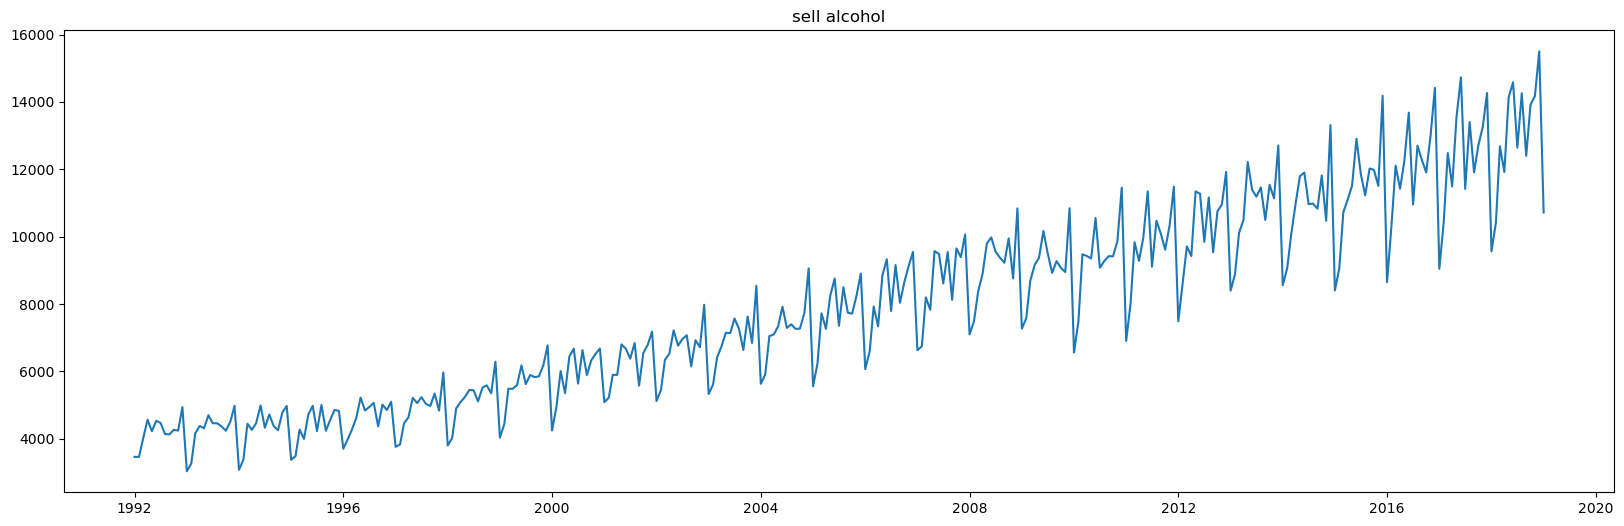

In [6]:
import matplotlib.ticker as mticker

fig,ax = plt.subplots(figsize=(20, 6))
plt.plot(time,series)
plt.title('sell alcohol')
plt.show()

### 划分训练集、测试集、batch

In [7]:
def train_test_split(series, split_prop): # split_prop: 训练集占比 
    train = series[:int(len(series)*split_prop)]
    test = series[int(len(series)*split_prop):]
    return train, test

# 将数据划分为指定大小的batch
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)])
        yield features.index_select(0, j), labels.index_select(0, j)

### 滑窗、划分特征/标签函数

In [8]:
# 滑窗、打乱
def data_process(train, test, window_size):
    # 将数据转为tensor，并进行滑窗，得到短序列
    train_tensor = torch.from_numpy(train)
    print('滑窗之前：', train_tensor.shape)
    train_tensor = train_tensor.squeeze()
    train_window_split = train_tensor.unfold(0, window_size, 1)
    print('滑窗之后：', train_window_split.shape)
    train_set = train_window_split.numpy()

    test_tensor = torch.from_numpy(test)
    print('滑窗之前：', test_tensor.shape)
    test_tensor = test_tensor.squeeze()
    test_window_split = test_tensor.unfold(0, window_size, 1)
    print('滑窗之后：', test_window_split.shape)
    test_set = test_window_split.numpy()

    # 打乱训练集数据
    train_temp1 = train_set.tolist()
    random.shuffle(train_temp1)
    train_templ2 = np.array(train_temp1)

    # 将短序列分为feature、label
    train_feature_array = train_templ2[:, :window_size-1]
    train_label_array = train_templ2[:, window_size-1:]
    test_feature_array = test_set[:, :window_size-1]
    test_label_array = test_set[:, window_size-1:]

    # 将 ndarray转为tensor
    train_feature_tensor = torch.from_numpy(train_feature_array).double()
    train_label = torch.from_numpy(train_label_array).double()
    test_feature_tensor = torch.from_numpy(test_feature_array).double()
    test_label = torch.from_numpy(test_label_array).double()

    # 扩展数据维度，符合 CNN 输入(样本数，通道数，特征数)
    train_feature = train_feature_tensor.reshape(train_feature_tensor.shape[0], 1, train_feature_tensor.shape[1])
    test_feature = test_feature_tensor.reshape(test_feature_tensor.shape[0], 1, test_feature_tensor.shape[1])

    return train_feature, train_label, test_feature, test_label

### 数据处理

In [232]:
split_prop = 0.7
train, test = train_test_split(series, split_prop)
window_size = 13
# 数据处理
train_feature, train_label, test_feature, test_label = data_process(train, test, window_size)
# 分别输出训练集、测试集的特征和标签
print(train_feature.shape)
print(train_label.shape)
print(test_feature.shape)
print(test_label.shape)

滑窗之前： torch.Size([227])
滑窗之后： torch.Size([215, 13])
滑窗之前： torch.Size([98])
滑窗之后： torch.Size([86, 13])
torch.Size([215, 1, 12])
torch.Size([215, 1])
torch.Size([86, 1, 12])
torch.Size([86, 1])


### 复现一维卷积神经网络

In [10]:
# 定义卷积神经网络
class ConvModule1(nn.Module):
    def __init__(self):
        super(ConvModule1, self).__init__()
        # 一层一维卷积
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )
        # 将输出通道变为单值
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        out = self.conv1(x) # 一维卷积
        out = F.max_pool1d(out, kernel_size=2, padding=1) # 最大池化
        out = self.conv2(out) # 一维卷积
        out = F.max_pool1d(out, 3) # 最大池化
        out = out.squeeze()
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
# 构建网络
net = ConvModule1().to(device)

平均池化

In [11]:
# 定义卷积神经网络
class ConvModule1(nn.Module):
    def __init__(self):
        super(ConvModule1, self).__init__()
        # 一层一维卷积
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )
        # 将输出通道变为单值
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        out = self.conv1(x) # 一维卷积
        out = F.avg_pool1d(out, kernel_size=2, padding=1) # 最大池化
        out = self.conv2(out) # 一维卷积
        out = F.avg_pool1d(out, 3) # 最大池化
        out = out.squeeze()
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
# 构建网络
net = ConvModule1().to(device)

In [12]:
# 定义损失函数-均方误差
def square_loss(feature, label):
    return (net(feature) - label)**2/2

### 参数初始化

In [13]:
for params in net.parameters():
    nn.init.normal_(params, mean=0, std=0.01)

lr = 0.01
num_epochs = 300
batch_size = 64
loss = square_loss
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

### 训练模型

In [14]:
train_loss, test_loss = [], []
# 模型训练
for epoch in range(num_epochs):
    train_l, test_l = 0.0, 0.0
    for X,y in data_iter(batch_size, train_feature, train_label):
        X, y = X.to(device), y.to(device)
        l = loss(X, y).sum() # 计算 loss
        # 梯度清零
        if optimizer is not None:
            optimizer.zero_grad()
        elif params is not None and params[0].grad is not None:
            for param in params:
                param.grad.data.zero_()
        l.backward() # 反向传播
        optimizer.step() # 更新参数
    
    train_l = loss(train_feature.to(device), train_label.to(device)).mean().detach().item()
    test_l = loss(test_feature.to(device), test_label.to(device)).mean().detach().item()
    train_loss.append(train_l)
    test_loss.append(test_l)
    print('epoch %d, train loss: %f, test loss: %f' % (epoch+1, train_l, test_l))

epoch 1, train loss: 15680842.145698, test loss: 45814802.862827
epoch 2, train loss: 22342068.190479, test loss: 65142040.042103
epoch 3, train loss: 5168287.852023, test loss: 15169961.216768
epoch 4, train loss: 10599827.842396, test loss: 31005676.806279
epoch 5, train loss: 4462993.627751, test loss: 13115539.120230
epoch 6, train loss: 3440270.205412, test loss: 10099298.600513
epoch 7, train loss: 346206.416730, test loss: 1100011.863798
epoch 8, train loss: 2210052.332548, test loss: 6545857.688128
epoch 9, train loss: 545072.206781, test loss: 1686396.656910
epoch 10, train loss: 1280424.413560, test loss: 3813930.786002
epoch 11, train loss: 334742.041312, test loss: 1070607.924679
epoch 12, train loss: 721392.821736, test loss: 2201904.297070
epoch 13, train loss: 369639.333431, test loss: 1167833.121574
epoch 14, train loss: 373698.157787, test loss: 1179589.227428
epoch 15, train loss: 414806.884026, test loss: 1305722.760338
epoch 16, train loss: 302086.576672, test loss:

### 绘制损失函数曲线

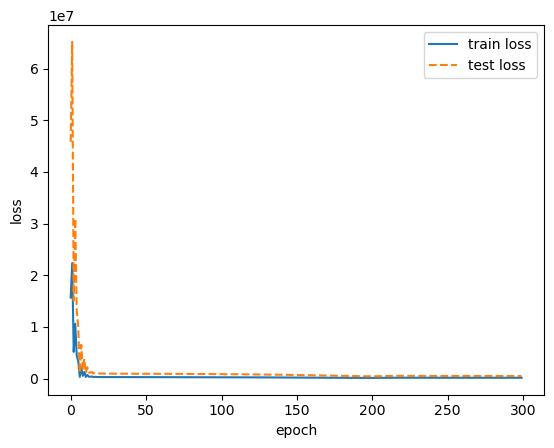

In [15]:
x = np.arange(num_epochs)
plt.plot(x, train_loss, label='train loss')
plt.plot(x, test_loss, label='test loss', linestyle='--')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

### 预测并对比

In [16]:
def predict(x):
    temp = torch.from_numpy(x)
    x_tensor = temp.reshape(1, 1, window_size-1) # 一次只输入一个样本
    return net(x_tensor)

In [17]:
time = data.index.to_list()

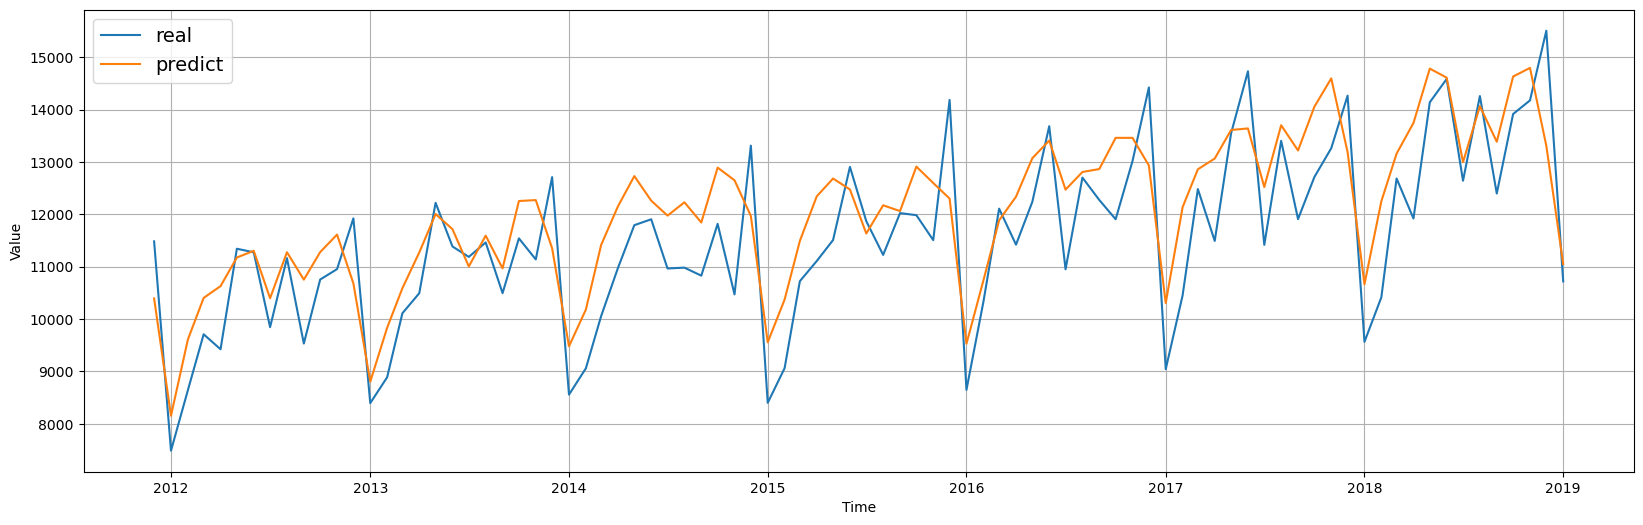

In [18]:
# net = net.to('cpu') # 把 net单独拆下来，放到cpu上；要不然就得把数据搬到 GPU 上

test_predict = []
split_point = int(split_prop * len(series))
test_time = time[split_point+window_size-1:] # 测试集时间 
test_true = series[split_point+window_size-1:] # 测试集真实值
test_predict = net(test_feature.to(device)).squeeze().tolist() # 测试集预测值

plt.figure(figsize=(20, 6))
plot_series(test_time, test_true, label='real')
plot_series(test_time, test_predict, label='predict')
plt.show()

In [19]:
from sklearn.metrics import mean_absolute_error as mae

print('MAE:', mae(test_true, test_predict))

MAE: 863.4849990584668


## 下面对网络结构进行调整

### 使用 GRU

In [351]:
# 构建 LSTM + Transformer 网络
class LSTMTransformerNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, nhead):
        super(LSTMTransformerNet, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.transformer = nn.Transformer(
            d_model=hidden_size, 
            nhead=nhead, 
            num_encoder_layers=num_layers, 
            num_decoder_layers=num_layers, 
            dim_feedforward=hidden_size, 
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # LSTM expects input of shape (batch_size, seq_length, input_size)
        lstm_out, _ = self.lstm(x)
        # Transformer expects input of shape (batch_size, seq_length, hidden_size)
        transformer_out = self.transformer(lstm_out, lstm_out)
        out = self.fc(transformer_out[:, -1, :])
        return out

In [357]:
# 定义模型参数
net = LSTMTransformerNet(input_size=12, hidden_size=64, num_layers=2, output_size=1, nhead=4).to(device)

In [358]:
# 定义损失函数-均方误差
def square_loss(feature, label):
    return (net(feature) - label)**2/2

### 参数初始化

In [359]:
for params in net.parameters():
    nn.init.normal_(params, mean=0, std=0.01)

lr = 0.1
num_epochs = 40
batch_size = 16
loss = square_loss
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [360]:
# train_feature.shape => torch.Size([215, 1, 12]) 也就是（batch_size, 通道数，特征数）
# 但LSTM 要求的输入是（batch_size, 序列长度，特征数）

# train_feature2 = train_feature.transpose(1,2)
# test_feature2 = test_feature.transpose(1,2)

train_feature2 = train_feature
test_feature2 = test_feature

train_feature2.shape

torch.Size([215, 1, 12])

### 训练模型

In [361]:
train_loss, test_loss = [], []
# 模型训练
for epoch in range(num_epochs):
    train_l, test_l = 0.0, 0.0
    for X,y in data_iter(batch_size, train_feature2, train_label):
        X, y = X.to(device), y.to(device)
        # print(X.shape, y.shape)
        l = loss(X, y).sum() # 计算 loss
        # 梯度清零
        if optimizer is not None:
            optimizer.zero_grad()
        elif params is not None and params[0].grad is not None:
            for param in params:
                param.grad.data.zero_()
        l.backward() # 反向传播
        optimizer.step() # 更新参数
    
    train_l = loss(train_feature2.to(device), train_label.to(device)).mean().detach().item()
    test_l = loss(test_feature2.to(device), test_label.to(device)).mean().detach().item()
    train_loss.append(train_l)
    test_loss.append(test_l)
    print('epoch %d, train loss: %f, test loss: %f' % (epoch+1, train_l, test_l))

epoch 1, train loss: 22128302.540471, test loss: 65806703.034087
epoch 2, train loss: 17621588.607863, test loss: 57567732.110011
epoch 3, train loss: 9836950.957050, test loss: 41754049.000430
epoch 4, train loss: 3170620.121674, test loss: 23410176.570946
epoch 5, train loss: 1824324.642964, test loss: 12435204.971563
epoch 6, train loss: 1833531.970085, test loss: 12351461.983363
epoch 7, train loss: 1791791.169329, test loss: 14199637.700435
epoch 8, train loss: 1783754.215297, test loss: 13841458.979395
epoch 9, train loss: 1783969.116091, test loss: 13903155.199909
epoch 10, train loss: 1783682.786713, test loss: 13872408.375121
epoch 11, train loss: 1788728.530306, test loss: 13860972.189110
epoch 12, train loss: 1783882.132251, test loss: 13881759.884081
epoch 13, train loss: 1790500.761859, test loss: 13847452.093470
epoch 14, train loss: 1783992.015362, test loss: 13809102.266526
epoch 15, train loss: 1785047.648845, test loss: 13866193.653579
epoch 16, train loss: 1792041.81

### 绘制损失函数曲线

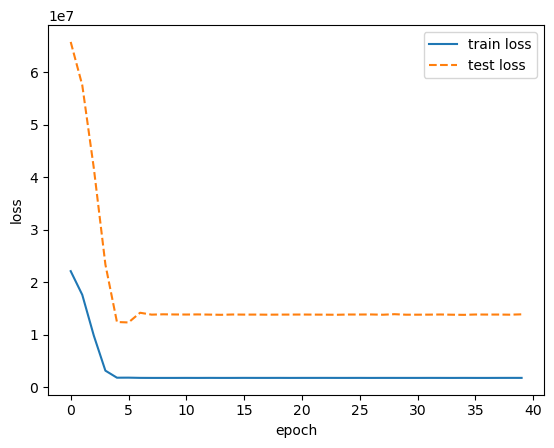

In [362]:
x = np.arange(num_epochs)
plt.plot(x, train_loss, label='train loss')
plt.plot(x, test_loss, label='test loss', linestyle='--')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

### 预测并对比

In [363]:
def predict(x):
    temp = torch.from_numpy(x)
    x_tensor = temp.reshape(1, 1, window_size-1) # 一次只输入一个样本
    return net(x_tensor)

In [364]:
time = data.index.to_list()

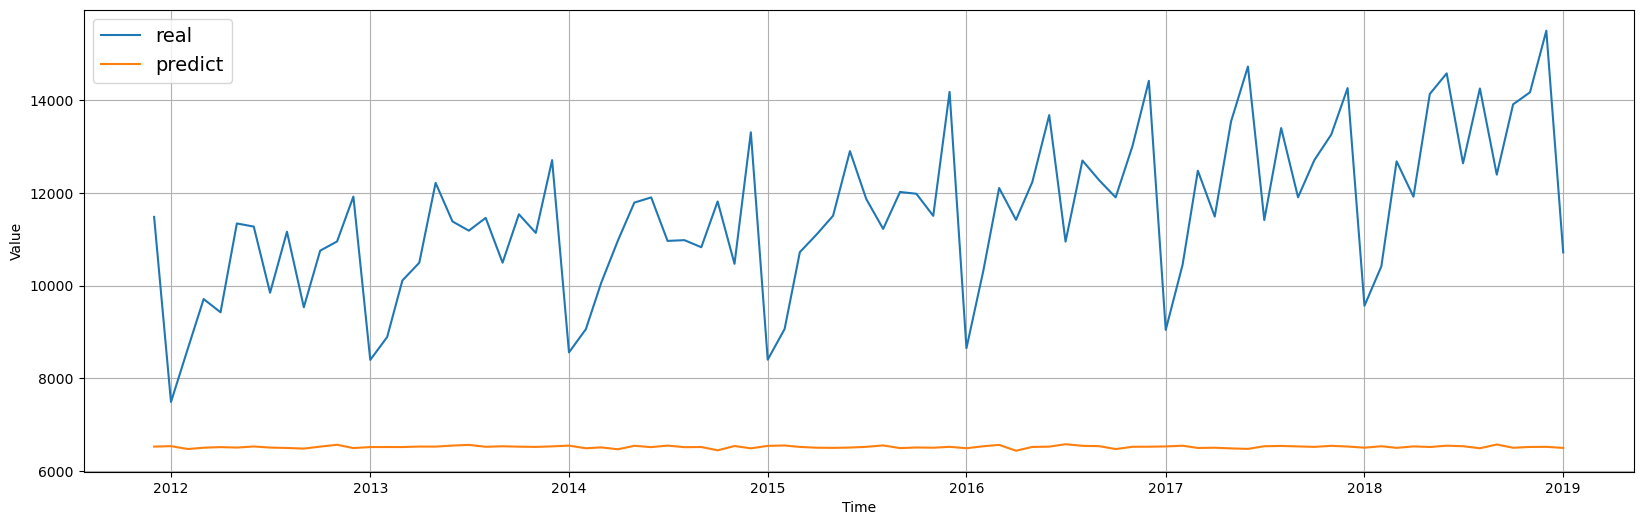

In [365]:
# net = net.to('cpu') # 把 net单独拆下来，放到cpu上；要不然就得把数据搬到 GPU 上

test_predict = []
split_point = int(split_prop * len(series))
test_time = time[split_point+window_size-1:] # 测试集时间 
test_true = series[split_point+window_size-1:] # 测试集真实值
test_predict = net(test_feature2.to(device)).detach().squeeze().tolist() # 测试集预测值

plt.figure(figsize=(20, 6))
plot_series(test_time, test_true, label='real')
plot_series(test_time, test_predict, label='predict')
plt.show()

In [366]:
from sklearn.metrics import mean_absolute_error as mae

print('MAE:', mae(test_true, test_predict))

MAE: 4997.1327110755265
